Group: Quantum Computing Knights (QuaCK)

Members: Adonai Hilário da Silva, Arthur Dutra de Oliveira, Claudio Alves Pessoa Junior, Gustavo Kerdole Gontijo, Ygor de Castro Lourenço

# **\(1\) [Exercise]**
**Obtaining expectation value of a Hamiltonian**



Considering the following Hamiltonian:

$$K = \displaystyle\dfrac{1}{3} \sum_{i<j} X_iX_j - \sum_{i=0}^{n-1}Z_i,$$

the code must receive the number of qubits and return the expectation value $K$ for $|\psi⟩$.

In [14]:
# Installing required libraries
!pip install pennylane

In [15]:
# Import required libraries
import pennylane as qml

In [16]:
# Define the Hamiltonian K
def Hamiltonian(qubits):

  # First sum of X gates
  op1 = 0
  for j in range(qubits):
    for i in range(j):
      op1 += qml.PauliX(i) @ qml.PauliX(j)

  # Second sum of Z gates
  op2 = 0
  for i in range(qubits):
    op2 += qml.PauliZ(i)

  # The final hamiltonian
  coeffs = [1/3, -1]
  obs = [op1, op2]
  return qml.Hamiltonian(coeffs, obs)

# The final funtion, that returns the expectation value for a given number
# of qubits:

def K_exp_value(qubits):
  # Define the hamiltonian
  K = Hamiltonian(qubits)

  # Choosing our device
  dev = qml.device("default.qubit", wires=qubits)

  # The circuit:
  @qml.qnode(dev)
  def circuit(qubits, K):
    for i in range(qubits):
      qml.Hadamard(wires=i) # Applying Hadamard gate to all the qubits

    return qml.expval(K)

  expectation_value = circuit(qubits, K)
  print(f"The expectation value of K for the final state, with {qubits} qubits is: {expectation_value}")

  # Draw circuit
  print(qml.draw_mpl(circuit)(qubits, K))

Testing it for number of qubits equal to 4:

The expectation value of K for the final state, with 5 qubits is: 3.333333333333334
(<Figure size 400x600 with 1 Axes>, <Axes: >)


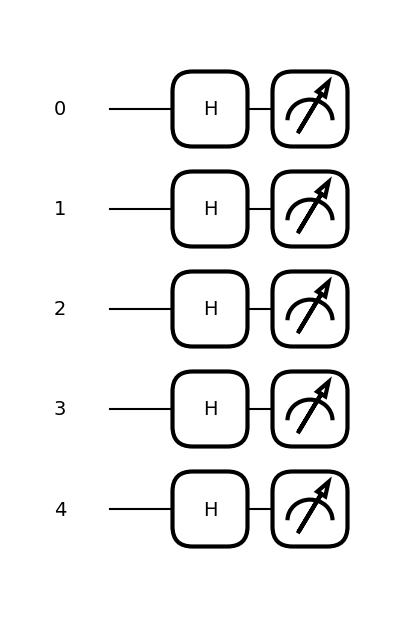

In [17]:
K_exp_value(5)

# **\(2\) [Challenge] \(a\)**
**Ground state energy for molecule and spin system with Variational Quantum Algorithms and Trotterization**


You must implement a function in Pennylane that simulates the Variational Quantum
Eigensolver (VQE). This function should take as input a six-entry array of floating-point numbers, representing the x, y and z coordinates of two hydrogen atoms. The first three entries correspond to the coordinates of the first hydrogen atom, and the remaining
three entries represent the coordinates of the second hydrogen atom. The function should return the ground state energy of the molecule.

In [18]:
# Installing required libraries
!pip install pennylane

In [19]:
# Import required libraries
import pennylane as qml
from pennylane import numpy as pnp

In [20]:
# Definitions

# Define variational circuit that prepares ansatze
def circuit_H2_VQE(param, wires, initial_state):
    #Prepares HF basis state in the circuit to initialize the circuit
    qml.BasisState(initial_state, wires=wires)
    #Parametrize coupling between HF state and doubly-excited state
    qml.DoubleExcitation(param, wires = [0,1,2,3])


# Function that uses VQE to find the ground state energy of a given geometry
# of a 2 hidrogen molecule

def ground_state_energy(coordinates_input):

  # Array of positions of the two hidrogen atoms
  coordinates = pnp.array([coordinates_input[0:3], coordinates_input[3:6]])
  symbols = ["H", "H"]

  # Building the molecular Hamiltonian (in second-quantized form and mapped to qubits via Jordan-Wigner transformation)

  # Using: STO-3G basis function set, multiplicity=1, charge=0:
  molecule = qml.qchem.Molecule(symbols, coordinates, charge=0, mult=1, basis_name='sto-3g')

  # Using Jordan-Wigner mapping:
  H, qubits = qml.qchem.molecular_hamiltonian(molecule, mapping='jordan_wigner')

  # Create the Hartree-Fock initial state for the molecule
  electrons = 2
  orbitals = qubits

  hf = qml.qchem.hf_state(electrons, orbitals)

  # Define device to use
  dev = qml.device("default.qubit", wires = qubits)

  # Create QNode associated with cost function
  @qml.qnode(dev)
  def Cost_fn(param, initial_state):

      circuit_H2_VQE(param, wires = range(qubits), initial_state=initial_state)

      return qml.expval(H)

#############################################################################

  # Choose an optimizer
  opt = qml.GradientDescentOptimizer(stepsize=0.4)

  # Choose an initial parameter for the variation circuit (angle of Givens rotation)
  theta = pnp.array(2.0, requires_grad=True)

  # Cost function
  cost_fn = lambda a: Cost_fn(a, hf)
  # This was defined this way, so it can be used inside a unique function
  # that returns the ground_state_energy

  # Store the values of the cost function
  energy = [cost_fn(theta)]

  # Store the values of the circuit parameter
  angle = [theta]

  max_interations = 40
  conv_tol = 1e-06

  # Repetition of optimization until convergence
  for n in range(max_interations):

      theta, prev_energy = opt.step_and_cost(cost_fn, theta)

      energy.append(cost_fn(theta))
      angle.append(theta)

      conv = pnp.abs(energy[-1] - prev_energy)

      if conv <= conv_tol: break

  print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
  print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Showing the final result below:

In [21]:
coordinates_input = [2,0,1,0,1,-1]
ground_state_energy(coordinates_input)


Final value of the ground-state energy = -0.98515244 Ha

Optimal value of the circuit parameter = 0.8086


Also explain why the Pauli-Z is necessary in Jordan-Wigner transformation.

The Jordan-Wigner transformation maps the fermionic Hamiltonian of the molecule into a spin Hamiltonian. In this new description, the Pauli-Z is used to define the spin Hamiltonian, and the spin of the particle is decribe by the eigenstate of the Pauli-Z operator. This is why the Pauli-Z is necessary in Jordan-Wigner transformation.



---



# **\(2\) [Challenge] \(b\)**
**Ground state energy for molecule and spin system with Variational Quantum Algorithms and Trotterization**

$$H=-\displaystyle \sum_{i=1}^{N} {Z_i \otimes Z_{i+1}} - h \sum_{i=1}^{N}{X_i}$$

You must implement a variational quantum algorithm in Pennylane that, for a given value of the transverse magnetic field h, computes the ground state energy of the spin chain with N = 4 sites. The magnetic field intensity h should be passed as an input to
the algorithm.

In [22]:
# Installing required libraries
!pip install pennylane

In [23]:
# Import required libraries
import pennylane as qml
from pennylane import numpy as pnp

In [24]:
qubits = 4 # Corresponds to the N = 4 sites

# Define the hamiltonian H

def Hamiltonian(h):
  N = 4 # Number of sites

  # First sum of Z gates
  op1 = 0
  for i in range(N):
    # Z(4) = Z(0), since it's a closed chain with N = 4, so we use (i+1)%N:
    op1 += qml.PauliZ(i) @ qml.PauliZ((i+1)%N)

  # Second sum of X gates
  op2 = 0
  for i in range(qubits):
    op2 += qml.PauliX(i)

  # The final hamiltonian
  coeffs = [-1, -h]
  obs = [op1, op2]
  return qml.Hamiltonian(coeffs, obs)

###################################################

# Define the device
dev = qml.device("default.qubit", wires=qubits)

# Build the VQE circuit:

def ansatz(theta):
  for i in range(qubits): qml.RY(theta[i] , wires = i)
  # Apply RY gates to all qubits

@qml.qnode(dev)
def cost_function(params, hamiltonian):
  ansatz(params)
  return qml.expval(hamiltonian)

########################################################

# Random theta

'''
Here we've defined a random array as our initial parameters for the
ansatz circuit, in order to test it. We're leaving it here, since we
are going to use it below to show some results.'''

import random

#Choose an initial parameter for the variation circuit
def Theta():
  theta = pnp.array([pnp.pi * random.random(), pnp.pi * random.random(), pnp.pi * random.random(), pnp.pi * random.random()])
  return theta

#########################################################

# Optimizing

def Optimize(initial_theta, h):

  H = Hamiltonian(h)

  # Choose an optimizer
  if abs(h) <= 1: opt = qml.GradientDescentOptimizer(stepsize=0.5)
  else: opt = qml.GradientDescentOptimizer(stepsize=1/abs(h))

  # Store the values of the cost function
  energy = [cost_function(initial_theta, H)]

  # Store the values of the circuit parameter
  angle = [initial_theta]

  max_interations = 1000
  conv_tol = 1e-06

  theta = initial_theta

  #Repetition of optimization until convergence
  for n in range(max_interations):

      theta, prev_energy = opt.step_and_cost((lambda theta: cost_function(theta, hamiltonian = H)), theta)
      # The lambda function was used because we have defined our cost_function
      # with the a hamiltonian as a parameter as well. This was done, so we could
      # define a unique function that returns the ground state, given a value of h.

      energy.append(cost_function(theta, H))
      angle.append(theta)
      # Store the new values

      conv = pnp.abs(energy[-1] - prev_energy)
      # Test the convergence of the new result

      if conv <= conv_tol: break

  return([energy[-1], len(energy)-1])
  # We return these, so we could print the informations with more details.

Testing the function for different values of $h$:

In [25]:
for h in [0,0.5,1,10,100, 1000]: # Value of transverse magnetic field h

  initial_theta = Theta()
  # We're using random initial parameters, but for no special reasons

  answer = Optimize(initial_theta, h)

  print(f"h = {h}: Final value of the ground-state energy = {answer[0]}")
  print(f"For initial theta: {initial_theta} and {answer[1]} interations\n")

h = 0: Final value of the ground-state energy = -4.0
For initial theta: [2.02456392 1.19830506 2.14864612 1.92788275] and 6 interations

h = 0.5: Final value of the ground-state energy = -4.249999998794217
For initial theta: [2.67035832 1.94315485 2.68889363 0.51170598] and 7 interations

h = 1: Final value of the ground-state energy = -4.999999991094356
For initial theta: [2.46128909 2.01971342 0.8193877  1.9740637 ] and 11 interations

h = 10: Final value of the ground-state energy = -39.999999992427554
For initial theta: [0.10995364 1.77344961 0.18356919 1.96749446] and 7 interations

h = 100: Final value of the ground-state energy = -399.999999999779
For initial theta: [2.09621066 1.40058425 2.37179534 2.74725097] and 4 interations

h = 1000: Final value of the ground-state energy = -3999.9999999999955
For initial theta: [0.09700556 0.30908389 2.50216235 2.58074816] and 4 interations



# **\(2\) [Challenge] (c)**
**Ground state energy for molecule and spin system with Variational Quantum Algorithms and Trotterization**

Unitary evolution of a quantum system:
$$U(t)=\exp{[-iHt]}$$
Trotterization method:
$$H=\displaystyle\sum_{i=1}^k {H_i} \Rightarrow U(t) \approx \prod_{j=1}^n \prod_{i=1}^k \exp{\left(-\dfrac{iH_it}{n}\right) }$$
For the Hamiltonian:
$$H=\alpha X\otimes X +\beta Z\otimes Z$$
in the state |00>.



In this case, applying Trotterization means the following:
$$H=\displaystyle\alpha X\otimes X +\beta Z\otimes Z$$
$$\Rightarrow U(t) \approx \prod_{j=1}^n \exp{\left(-\dfrac{i\alpha X\otimes Xt}{n}\right)} \exp{\left(-\dfrac{i\beta Z\otimes Zt}{n}\right)}$$

In [26]:
# Installing required libraries
!pip install pennylane

In [27]:
# Import required libraries
import pennylane as qml
from pennylane import numpy as pnp

In [28]:
# Firstly, defining the operator from the hamiltonian
h1 = qml.PauliX(0) @ qml.PauliX(1)
h2 = qml.PauliZ(0) @ qml.PauliZ(1)

# Define the device
dev = qml.device("default.qubit", wires = 2)

# Build the circuit of the Trotterizaton method:
@qml.qnode(dev)
def circuit(alpha, beta, t, n):
  for i in range(n):
    exp1 = qml.exp(h1, coeff = -1j*alpha*t/n) # exp for H1
    exp2 = qml.exp(h2, coeff = -1j*beta*t/n) # exp for H2
  return qml.state() # Return the state for calculating the probabilities

# Function that receives the input from the problem and return the probabilities of measurements (+ extra infos)
def prob_by_trotter(alpha, beta, t, n):
  c = circuit(alpha, beta, t, n) # Applies the circuit to the initial state
  prob = [float(pnp.absolute(a)**2) for a in c] # Calculates the probabilities
  print(f"For t = {t} and n = {n}, the final state is:\n")
  print(f"({c[0]:.2f})|00> + ({c[1]:.2f})|01> + ({c[2]:.2f})|10> + ({c[3]:.2f})|11>\n")
  print(f"And the probabilities of measuring each basis state is:\n")
  print(f"P(00): {prob[0]:.2f},\nP(01): {prob[1]:.2f},\nP(10): {prob[2]:.2f},\nP(11): {prob[3]:.2f}.\n")
  print(f"The circuit of the Trotterization is as the following:\n")
  print(qml.draw_mpl(circuit)(alpha, beta, t, n))
  return prob # Return the probabilities in case you want to use them

Testing it for the following values of $\alpha$, $\beta$, $t$ and $n$:

For t = 1 and n = 1, the final state is:

(0.18-0.22j)|00> + (0.00+0.00j)|01> + (0.00+0.00j)|10> + (0.74+0.61j)|11>

And the probabilities of measuring each basis state is:

P(00): 0.08,
P(01): 0.00,
P(10): 0.00,
P(11): 0.92.

The circuit of the Trotterization is as the following:

(<Figure size 500x300 with 1 Axes>, <Axes: >)


[0.08046423546177364, 0.0, 0.0, 0.9195357645382259]

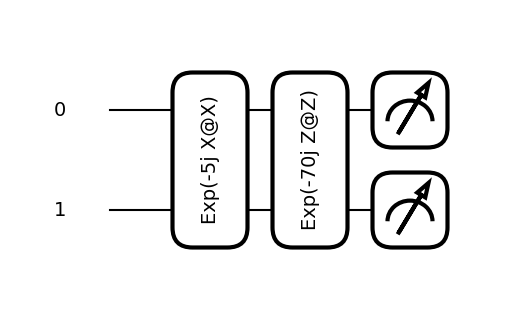

In [29]:
# An example
prob_by_trotter(5,70,1,1)

Extra plot out of curiosity: Ploting the probabilities of measuring $|00⟩$ and $|11⟩$ in function of time, as they are the only non-zero probabilities.

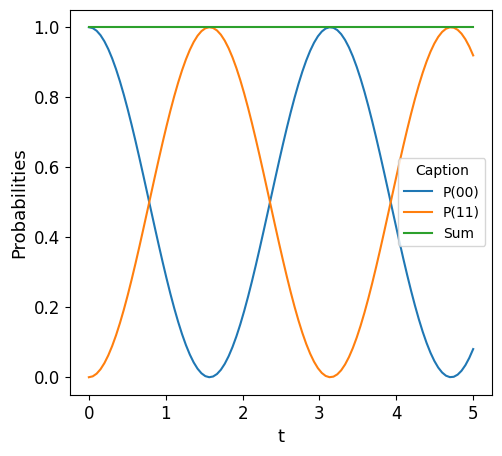

In [30]:
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as pnp

# Ploting the probabilities of measuring |00> and |11> in function of time

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

T = pnp.linspace(0,5,100)

# Formimng lists with the desired probabilities
Prob00 = []
Prob11 = []
ProbT = [] # To see that they really sum up to 1
for t in T:
  c = circuit(1, 1, t, 10)
  p00 = float(pnp.absolute(c[0])**2)
  p11 = float(pnp.absolute(c[3])**2)
  Prob00.append(p00)
  Prob11.append(p11)
  ProbT.append(p00+p11)

# Ploting each of the list above in function of time
ax1 = fig.add_subplot(121)
ax1.plot(T, Prob00)
ax1.plot(T, Prob11)
ax1.plot(T, ProbT)
ax1.set_xlabel("t", fontsize=13)
ax1.set_ylabel("Probabilities", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(("P(00)", "P(11)", "Sum"), title='Caption')

#plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()